# League of Legends Champion Analysis

This notebook contains analyses of champion performance, winrates, and matchups from ranked solo matches.

**Player**: tattpåfersken (EUNE)  
**Period**: August 2024 - Present  
**Queue**: Ranked Solo/Duo (420)


## Directory

- [Champion Winrates (Zoe Games)](#champion-winrates-zoe-games) - Winrate with and against each champion in matches where you played Zoe


---

## Champion Winrates (Zoe Games) {#champion-winrates-zoe-games}

Analyze winrates with teammates and against enemies for matches where you played Zoe.

**Questions:**
- Which champions do you win most with when playing Zoe?
- Which enemy champions do you struggle against when playing Zoe?
- Are there specific champion combinations that work well with Zoe?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Load the match data
df = pd.read_csv('../data/lol_matches.csv')

# Convert gameDate to datetime
df['gameDate'] = pd.to_datetime(df['gameDate'])

print(f"Total matches: {len(df)}")
print(f"Date range: {df['gameDate'].min().date()} to {df['gameDate'].max().date()}")
print(f"\nChampions played:")
print(df['championName'].value_counts())


Total matches: 216
Date range: 2025-03-30 to 2025-11-28

Champions played:
championName
Zoe           166
Zilean         18
Bard            7
Malphite        4
Morgana         3
Blitzcrank      3
Xayah           3
Amumu           2
Janna           2
Akali           2
Thresh          2
Zyra            1
Rakan           1
Karma           1
Alistar         1
Name: count, dtype: int64


/tmp/ipykernel_190063/471670099.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['gameDate'] = pd.to_datetime(df['gameDate'])


In [2]:
# Filter to Zoe games only
zoe_games = df[df['championName'] == 'Zoe'].copy()

print(f"Total Zoe games: {len(zoe_games)}")
print(f"Zoe win rate: {(zoe_games['win'].mean() * 100):.1f}%")
print(f"Wins: {zoe_games['win'].sum()}, Losses: {(~zoe_games['win']).sum()}")

if len(zoe_games) == 0:
    print("\n⚠️  No Zoe games found in the dataset!")
else:
    zoe_games.head()


Total Zoe games: 166
Zoe win rate: 54.8%
Wins: 91, Losses: 75


### Load Full Match Data to Get Team Compositions

We need to load the full match data to see which champions were on your team and enemy team.


In [3]:
import json

# Load the raw match data
with open('../data/lol_matches_raw.json', 'r') as f:
    raw_matches = json.load(f)

# Create a mapping of matchId to full match data
match_dict = {match['metadata']['matchId']: match for match in raw_matches}

print(f"Loaded {len(match_dict)} matches from raw data")
print(f"Zoe game match IDs: {len(zoe_games)}")

# Get the match IDs for Zoe games
zoe_match_ids = set(zoe_games['matchId'].values)
print(f"Unique Zoe match IDs: {len(zoe_match_ids)}")


Loaded 216 matches from raw data
Zoe game match IDs: 166
Unique Zoe match IDs: 166


In [4]:
# Get PUUID from the first match (should be consistent)
# We'll get it from the Zoe games dataframe - need to find it in raw data
sample_match_id = zoe_games.iloc[0]['matchId']
sample_match = match_dict.get(sample_match_id)

if sample_match:
    # Find your PUUID from participants
    participants = sample_match['info']['participants']
    your_puuid = None
    for p in participants:
        if p['championName'] == 'Zoe':
            your_puuid = p['puuid']
            break
    
    print(f"Your PUUID: {your_puuid}")
else:
    print("Could not find sample match!")


Your PUUID: 3EqqeT7jqP2LDWpN-zjaAA7uiL66Mc_a3ecBtxMAUTkL_EvMp6oQVdDjE7bZBshSqhGomvYEijFC5w


In [5]:
# Analyze winrates with teammates and against enemies for Zoe games
champions_with = defaultdict(lambda: {'wins': 0, 'games': 0})
champions_against = defaultdict(lambda: {'wins': 0, 'games': 0})

for match_id in zoe_match_ids:
    match_data = match_dict.get(match_id)
    if not match_data:
        continue
    
    # Get match result (win/loss)
    info = match_data['info']
    participants = info['participants']
    
    # Find your team ID
    your_team_id = None
    match_result = None  # True = win, False = loss
    
    for p in participants:
        if p['puuid'] == your_puuid:
            your_team_id = p['teamId']
            match_result = p['win']
            break
    
    if your_team_id is None:
        continue
    
    # Analyze teammates (same team, different champion)
    for p in participants:
        if p['puuid'] == your_puuid:
            continue  # Skip yourself
        
        champ_name = p['championName']
        
        if p['teamId'] == your_team_id:
            # Teammate
            champions_with[champ_name]['games'] += 1
            if match_result:
                champions_with[champ_name]['wins'] += 1
        else:
            # Enemy
            champions_against[champ_name]['games'] += 1
            if match_result:
                champions_against[champ_name]['wins'] += 1

print(f"Processed {len(zoe_match_ids)} Zoe matches")
print(f"Found {len(champions_with)} unique teammate champions")
print(f"Found {len(champions_against)} unique enemy champions")


Processed 166 Zoe matches
Found 140 unique teammate champions
Found 163 unique enemy champions


In [6]:
# Calculate winrates and create DataFrames
def create_winrate_df(champ_dict, title_prefix):
    data = []
    for champ, stats in champ_dict.items():
        winrate = (stats['wins'] / stats['games'] * 100) if stats['games'] > 0 else 0
        data.append({
            'Champion': champ,
            'Games': stats['games'],
            'Wins': stats['wins'],
            'Losses': stats['games'] - stats['wins'],
            'Winrate': winrate
        })
    
    df_result = pd.DataFrame(data)
    df_result = df_result.sort_values('Games', ascending=False)
    return df_result

# Create DataFrames
teammates_df = create_winrate_df(champions_with, 'With')
enemies_df = create_winrate_df(champions_against, 'Against')

print("=" * 60)
print("WINRATES WITH TEAMMATES (When playing Zoe)")
print("=" * 60)
print(teammates_df.to_string(index=False))

print("\n" + "=" * 60)
print("WINRATES AGAINST ENEMIES (When playing Zoe)")
print("=" * 60)
print(enemies_df.to_string(index=False))


WINRATES WITH TEAMMATES (When playing Zoe)
    Champion  Games  Wins  Losses    Winrate
     Smolder     22    12      10  54.545455
     Caitlyn     21    10      11  47.619048
      Khazix     17    11       6  64.705882
        Jhin     15     9       6  60.000000
       Diana     15     7       8  46.666667
       Yasuo     13     8       5  61.538462
         Zed     13     8       5  61.538462
        Jinx     12     7       5  58.333333
       Sivir     11     6       5  54.545455
      Darius     11     4       7  36.363636
 MissFortune     11     9       2  81.818182
        Yone     11     9       2  81.818182
       Kaisa     11     4       7  36.363636
    JarvanIV     10     5       5  50.000000
         Lux      9     4       5  44.444444
    MasterYi      9     5       4  55.555556
      LeeSin      8     4       4  50.000000
     DrMundo      8     5       3  62.500000
        Sion      8     5       3  62.500000
       Viego      8     2       6  25.000000
      Ezreal

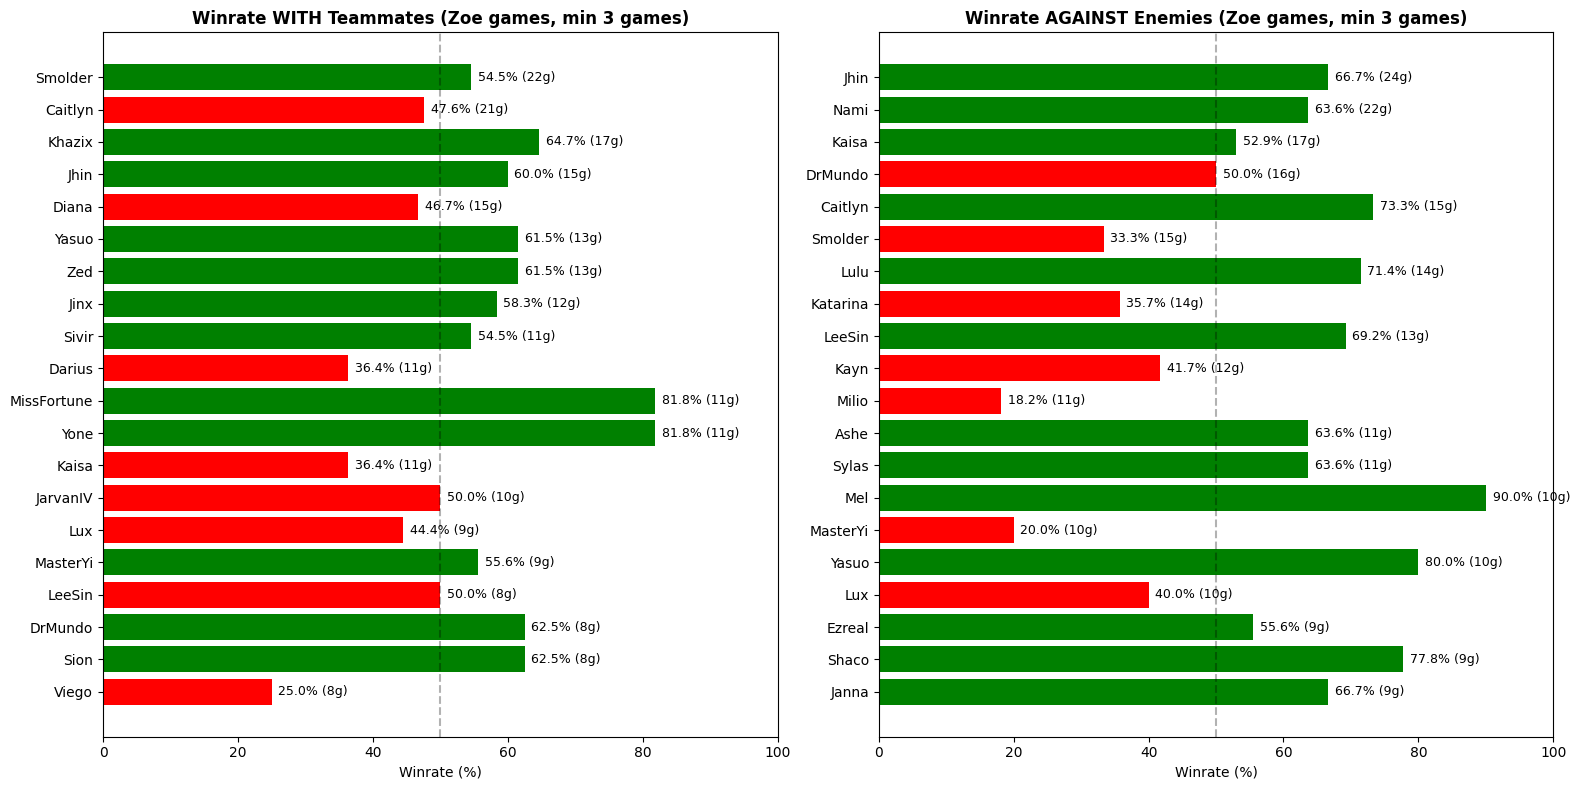


Note: Only showing champions with at least 3 games for statistical significance


In [7]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Filter to champions with at least 3 games for better statistical significance
min_games = 3

# Teammates
teammates_filtered = teammates_df[teammates_df['Games'] >= min_games].head(20)
ax1 = axes[0]
bars1 = ax1.barh(range(len(teammates_filtered)), teammates_filtered['Winrate'], 
                 color=['green' if w > 50 else 'red' for w in teammates_filtered['Winrate']])
ax1.set_yticks(range(len(teammates_filtered)))
ax1.set_yticklabels(teammates_filtered['Champion'])
ax1.set_xlabel('Winrate (%)')
ax1.set_title(f'Winrate WITH Teammates (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax1.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax1.set_xlim(0, 100)
ax1.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(teammates_filtered.iterrows()):
    ax1.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

# Enemies
enemies_filtered = enemies_df[enemies_df['Games'] >= min_games].head(20)
ax2 = axes[1]
bars2 = ax2.barh(range(len(enemies_filtered)), enemies_filtered['Winrate'],
                 color=['green' if w > 50 else 'red' for w in enemies_filtered['Winrate']])
ax2.set_yticks(range(len(enemies_filtered)))
ax2.set_yticklabels(enemies_filtered['Champion'])
ax2.set_xlabel('Winrate (%)')
ax2.set_title(f'Winrate AGAINST Enemies (Zoe games, min {min_games} games)', fontsize=12, fontweight='bold')
ax2.axvline(x=50, color='black', linestyle='--', alpha=0.3)
ax2.set_xlim(0, 100)
ax2.invert_yaxis()

# Add value labels
for i, (idx, row) in enumerate(enemies_filtered.iterrows()):
    ax2.text(row['Winrate'] + 1, i, f"{row['Winrate']:.1f}% ({row['Games']}g)", 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\nNote: Only showing champions with at least {min_games} games for statistical significance")


---

## Luden's vs Shurelya's Comparison {#ludens-vs-shurelyas}

Compare performance metrics between games where you built Luden's Companion vs Shurelya's Battlesong.

**Questions:**
- Which item has a higher winrate?
- How does damage output differ?
- Are there differences in deaths, KDA, or other stats?
- When is each item more effective?


In [42]:
# Setup: Filter Zoe games by item and create statistical comparison
if 'pd' not in locals() and 'pd' not in globals():
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

if 'zoe_games' not in locals() and 'zoe_games' not in globals():
    if 'df' not in locals() and 'df' not in globals():
        df = pd.read_csv('../data/lol_matches.csv')
        df['gameDate'] = pd.to_datetime(df['gameDate'])
    zoe_games = df[df['championName'] == 'Zoe'].copy()

# Item IDs: Luden's Companion = 6655, Shurelya's Battlesong = 2065
LUDENS_ITEM_ID = 6655
SHURELYAS_ITEM_ID = 2065

# Filter Zoe games by item
def get_mythic_item(row):
    for i in range(7):
        item_id = row.get(f'item{i}', 0)
        if item_id == LUDENS_ITEM_ID:
            return 'Ludens'
        elif item_id == SHURELYAS_ITEM_ID:
            return 'Shurelyas'
    return None

zoe_games_with_items = zoe_games.copy()
zoe_games_with_items['mythic_item'] = zoe_games_with_items.apply(get_mythic_item, axis=1)
ludens_shurelyas_games = zoe_games_with_items[zoe_games_with_items['mythic_item'].notna()].copy()

ludens_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Ludens']
shurelyas_games = ludens_shurelyas_games[ludens_shurelyas_games['mythic_item'] == 'Shurelyas']

# Statistical comparison table
comparison_stats = ['win', 'kills', 'deaths', 'assists', 'kda', 
                    'totalDamageDealtToChampions', 'damagePerMin',
                    'goldEarned', 'goldPerMin', 'csPerMin', 
                    'visionScore', 'visionScorePerMin', 'killParticipation']

comparison_data = []
for stat in comparison_stats:
    ludens_mean = ludens_games[stat].mean()
    shurelyas_mean = shurelyas_games[stat].mean()
    difference = ludens_mean - shurelyas_mean
    pct_diff = (difference / shurelyas_mean * 100) if shurelyas_mean != 0 else 0
    
    comparison_data.append({
        'Stat': stat,
        'Ludens': round(ludens_mean, 2),
        'Shurelyas': round(shurelyas_mean, 2),
        'Difference': round(difference, 2),
        '% Difference': round(pct_diff, 1)
    })

comparison_table = pd.DataFrame(comparison_data)

print("=" * 70)
print("STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S")
print("=" * 70)
print(comparison_table.to_string(index=False))
print(f"\nSample sizes: Luden's: {len(ludens_games)} games | Shurelya's: {len(shurelyas_games)} games")


STATISTICAL COMPARISON: LUDEN'S vs SHURELYA'S
                       Stat   Ludens  Shurelyas  Difference  % Difference
                        win     0.53       0.56       -0.03          -5.2
                      kills     3.71       3.96       -0.25          -6.2
                     deaths     5.59       5.87       -0.28          -4.7
                    assists    11.02      13.83       -2.81         -20.3
                        kda     3.88       4.81       -0.93         -19.3
totalDamageDealtToChampions 20661.53   21374.12     -712.59          -3.3
               damagePerMin   696.18     657.28       38.90           5.9
                 goldEarned  9451.37   10195.47     -744.10          -7.3
                 goldPerMin   324.06     319.84        4.22           1.3
                   csPerMin     1.62       1.40        0.22          15.8
                visionScore    56.69      71.08      -14.39         -20.2
          visionScorePerMin     1.91       2.22       -0.32       

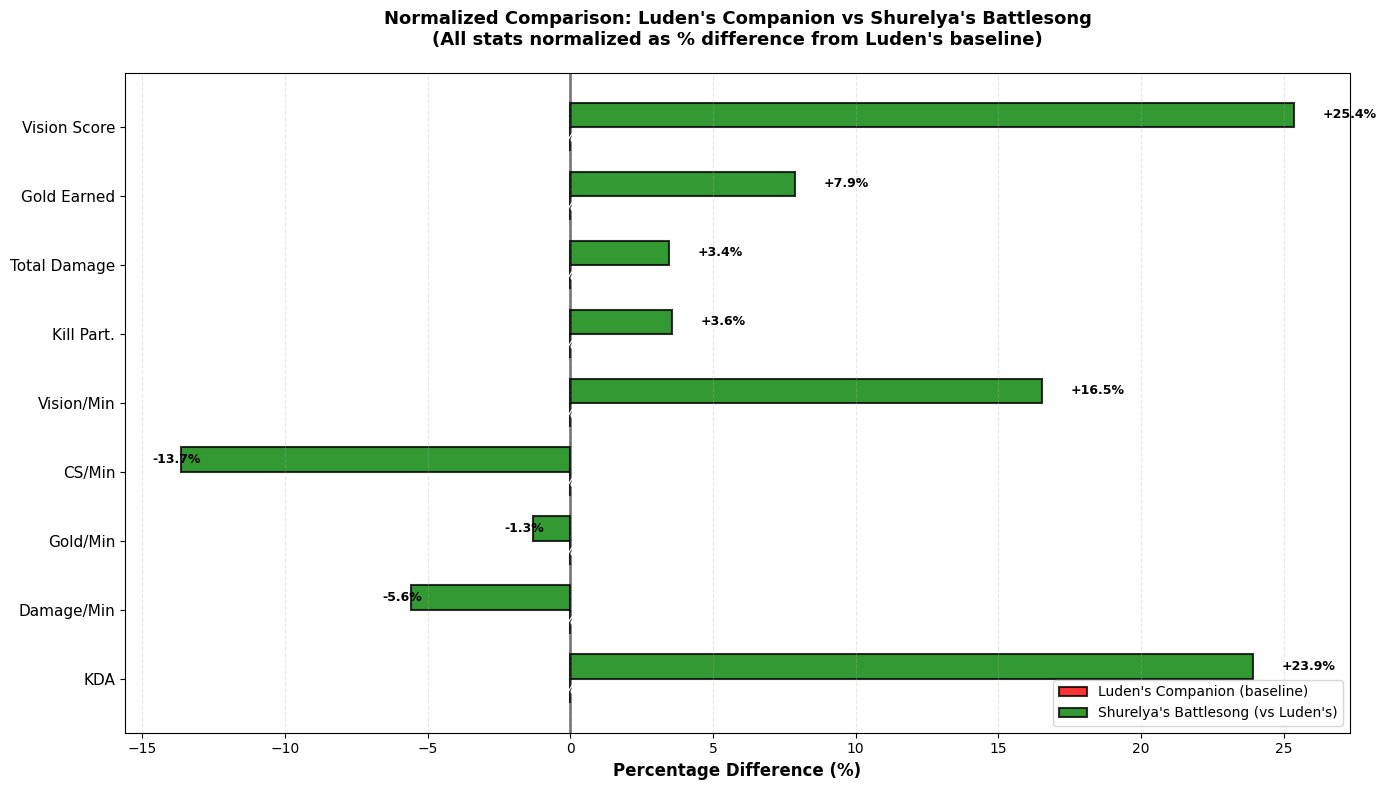

In [43]:
# Normalized percentage comparison chart
comparison_stats_normalized = {
    'KDA': 'kda',
    'Damage/Min': 'damagePerMin',
    'Gold/Min': 'goldPerMin',
    'CS/Min': 'csPerMin',
    'Vision/Min': 'visionScorePerMin',
    'Kill Part.': 'killParticipation',
    'Total Damage': 'totalDamageDealtToChampions',
    'Gold Earned': 'goldEarned',
    'Vision Score': 'visionScore'
}

# Calculate percentage differences (Shurelya's relative to Luden's)
normalized_data = []
for label, stat in comparison_stats_normalized.items():
    ludens_val = ludens_games[stat].mean()
    shurelyas_val = shurelyas_games[stat].mean()
    
    if ludens_val != 0:
        pct_diff = ((shurelyas_val - ludens_val) / ludens_val) * 100
    else:
        pct_diff = 0
    
    normalized_data.append({
        'Stat': label,
        'Luden\'s %': 0,  # Baseline at 0%
        'Shurelya\'s %': pct_diff
    })

normalized_df = pd.DataFrame(normalized_data)

# Create the visualization
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(normalized_df))
width = 0.35

# Create bars - Luden's at baseline (0), Shurelya's as percentage difference
# Red for Luden's, Green for Shurelya's
ludens_values = normalized_df['Luden\'s %'].values
shurelyas_values = normalized_df['Shurelya\'s %'].values

# Create bars with explicit colors
bars1 = ax.barh(x - width/2, ludens_values, width, 
                label='Luden\'s Companion (baseline)', 
                color='red', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.barh(x + width/2, shurelyas_values, width,
                label='Shurelya\'s Battlesong (vs Luden\'s)', 
                color='green', alpha=0.8, edgecolor='black', linewidth=1.5)

# Force set colors explicitly using facecolor (more reliable than color)
for i, bar in enumerate(bars1):
    bar.set_facecolor('red')
    bar.set_edgecolor('black')
for i, bar in enumerate(bars2):
    bar.set_facecolor('green')
    bar.set_edgecolor('black')

# Add value labels on bars
for i, (idx, row) in enumerate(normalized_df.iterrows()):
    shurelyas_pct = row['Shurelya\'s %']
    ax.text(0 + (1 if 0 > 0 else -1), i - width/2,
            '0.0%', va='center', fontweight='bold', fontsize=9, color='white')
    if abs(shurelyas_pct) > 1:
        ax.text(shurelyas_pct + (1 if shurelyas_pct > 0 else -1), i + width/2, 
                f'{shurelyas_pct:+.1f}%', va='center', fontweight='bold', fontsize=9)

ax.set_xlabel('Percentage Difference (%)', fontsize=12, fontweight='bold')
ax.set_title('Normalized Comparison: Luden\'s Companion vs Shurelya\'s Battlesong\n(All stats normalized as % difference from Luden\'s baseline)', 
             fontsize=13, fontweight='bold', pad=20)
ax.set_yticks(x)
ax.set_yticklabels(normalized_df['Stat'], fontsize=11)
ax.axvline(x=0, color='black', linestyle='-', linewidth=2, alpha=0.5)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


## Reflection
It seems that on most "carry" damage characters, I have great winrates. I do horrible against characters with surprisingly low cc, and well against characters with good cc.